# **Lab 16: Q-Learning**
---

**Disclaimer**

This notebook is a demonstration of using RL Algorithms - There is a lot of new code so the purpose of the lab is to build exposure and intuition about Reinforcement Learning.


## **Overview of Lab**
---

In this lab, you will be using the Q Learning Algorithm, which is a reinforcement learning algorithm. Unlike supervised or unsupervised algorithms, an RL model does not get trained on existing data. Instead, the RL models are fit by exploring an environment which gives them a reward for each decision they make.

In today's lab we will learn about an environment called **GridWorld**.

Gridworld is a game in which a player aims to travel from the start position to the goal position in the fewest moves possible. We will explore the game ourselves first, understand how rewards are given, and build a reinforcement learning agent that learns to play the game.



#### **Learning about the Gridworld**
---
***Read before implementing***

This game is called **Gridworld**. The goal of Gridworld is to get the red block (the player) to the blue block (the goal state) in the shortest distance possible.

* `Red` block represents the Agent

* `Blue` block represents the Goal State

* `Grey` blocks represent obstructions


#### **Let's Initialize a game:**

Running `new_game = Create_game()` will create a new instance of the game and store it in the variable `new_game`.

**Each instance of a game has four useful functions:**

1. `new_game.running` will return `True` if the game is in progress or `False` if the game is over.
2. `new_game.move(action)` will move the player in the game and returns two values:
  `current_state` and `reward`.

  ***There are 4 valid moves:***

  `0` Will move the player **North**

  `1` Will move the player **East**

  `2` Will move the player **South**

  `3` Will move the player **West** 
  
  As `.move()` returns two values, it is easiest to be called as follows:
  ```python
  state, reward = new_game.move(action)
  ``` 

3. `new_game.start_pos` will give the starting position of the player.

4. `new_game.display()` draws a visual representation of the game.

  **There are 2 optional arguments you can pass into `.display`:**
    1. `new_game.display(show_reward=True)` shows the reward associated with landing at each positon on the grid.
    2. `new_game.display(Q=Qvalues)` - By passing in the Q values of your RL agent you can visualize what the strategy of the Agent at each point of the map.

## **Part 1: Practice Together**
---
*Follow along with your TA to implement your first RL algorithm*

In Part 1 we will do the following:

1. Load in the game
2. Familiarize ourselves with the game and the associated rules
3. Create and train the RL agent
4. Observe the Agent playing the game
5. Visualize the strategy of the Agent


### **Step \#0: Import the following before continuing**
---

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython import display
import time

### **Step \#1: Load the Game generator**
---

This game generator, which is mostly for drawing the game visualizations, is completed for you. You may look at the code inside it, *but please do not edit it*.

The code is hidden but ***you must run the following cell.***

In [ ]:
#@title Create_game() { display-mode: "form" }
class Create_game():
  def __init__(self):
    # Game is running
    self.running = True
    self.display_init = False
    self.display_update = False
    # self.display_clear = False
    
    # Create border for 12x12
    self.grid = (12,12)
    self.blocks = np.array([142, 143, 3, 35, 8, 135, 84, 120, 139, 36, 133, 4, 9, 131,
                   71, 132, 23, 141, 5, 48, 10, 0, 59, 137, 138, 140, 119, 6, 
                   11, 60, 1, 96, 136, 12, 95, 7, 107, 134, 47, 2, 72, 108, 24, 83])

    # Add in goal, agent block
    self.goal_pos = 33
    self.start_pos = 75
    self.player_pos = 75
    
    # Create Reward Table
    self.rewards = np.ones((144)) * -1
    self.rewards[self.blocks] = -10
    self.rewards[self.goal_pos] = 50
   
  def display(self, show_rewards=False, Q=None):
    if self.display_init:
      self.ax.set_title("The Land of GridWorld")
      self.ax.axis('off')
      if show_rewards:
        for pos in range(len(self.rewards)):
            i, j = np.unravel_index(pos, self.grid, order="F")
            self.ax.text(i,j,self.rewards[pos],ha='center',va='center')
            self.display_init = False
      elif Q is not None:
        for pos in range(len(Q)):
          i, j = np.unravel_index(pos, self.grid, order="F")
          arrow_dict = {0:(0,0.4),1:(0.4,0),2:(0,-0.4),3:(-0.4,0)}
          dx, dy = arrow_dict[np.argmax(Q[pos,:])]
          self.ax.arrow(i, j , dx , dy , fc="k", ec="k", head_width=0.1, head_length=0.1)
        self.display_init = False
      temp_board = self.visual_board.copy()
      temp_board[self.player_pos] = (240, 15, 60)
      self.ax.imshow(temp_board.reshape(*self.grid,3), origin="lower")
      if self.display_update:
        self.hdisplay.update(self.fig)
      self.display_update = True

    else:
       # Prepare Rendering Engine
      self.hdisplay = display.display("12x12 Game Board", display_id=True)
      self.fig, self.ax = plt.subplots(figsize=(7,7))
      # Create Visual Board
      self.visual_board = np.array([(255,255,255) for _ in range(144)])
      self.visual_board[self.goal_pos] = (11, 218, 222)
      self.visual_board[self.blocks] = (120, 124, 125)
      self.display_init = True
      self.display_update = False
      self.display(show_rewards=show_rewards, Q=Q)

  def move(self, action):
    move_dict = {0:(1,0),1:(0,1),2:(-1,0),3:(0,-1)}
    # Convert action to a proposed new state in flat form
    cartesian_pos = np.unravel_index(self.player_pos, self.grid)
    move = move_dict[action]
    new_cartesian_pos = np.array(cartesian_pos) + np.array(move)
    new_pos = np.ravel_multi_index(new_cartesian_pos, self.grid)

    if new_pos == self.goal_pos:
      # Reached Goal State
      self.running = False
      self.player_pos = new_pos
    elif new_pos not in self.blocks:
      # Valid Move
      self.player_pos = new_pos

    return (self.player_pos, self.rewards[new_pos])

#### **Step #1.5 Play the game ourselves**
---
***This code is completed for you***

The Game can be played as a traditional user input game. Run this cell to open up an input box. 

To move the player (the red square) around, input:
0. North (Up)
1. East (Right)
2. South (Down)
3. West (Left)

In [ ]:
# Run the game with Human Input
simple_grid = Create_game()
while simple_grid.running:
  simple_grid.display()
  simple_grid.move(int(input("Enter your move: ")))

We can show the rewards associated with each position by passing the argument `show_rewards=True` into the display function:

***Run the code below to view the rewards for each position on the map.***


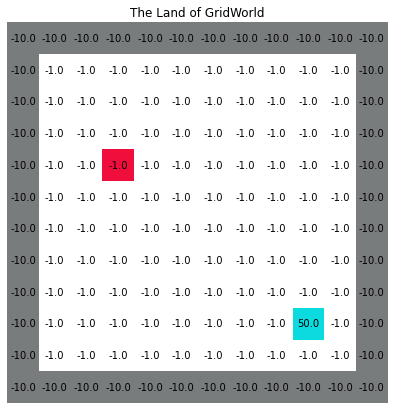

In [ ]:
simple_grid.display(show_rewards=True)

### **Step \#2, #3, and #4: Create the RL Agent**
---

In order to make the agent, you must create a **Q table** that is of the correct size (no. of states, no. actions).

Each column in our table represents taking a specific action. Therefore, column 0 represents action 0.

If we have a 12 x 12 grid, there are **144 states**.

If we can move `N`,`S`,`E`,`W` there are **4 actions**.

The general pseudocode is as follows:

```pseudocode
Create a Q table full of random numbers.

for episode in 100:
  Create a game
  Set the current_state equal to the starting game position
  while the game is running:
    Take the action which has the highest value for the current state
    Make a move in the game using that action and record the new_state and reward
    Update the Q table according to the Q function
    Update the current state to the new state
```

### **The Q function:**

$$
Q[S,A] = Q[S,A] + \alpha \{ reward + \gamma\max (Q[S_{new}]) - Q[S,A] \}
$$

For our purposes we will set the learning rate $\alpha$ `alpha = 0.5` and the discount factor $\gamma$ `gamma = 0.8` 

### **Useful functions:**

**Generating a table of random numbers**
>The `np.random.rand(x,y)` will create a grid of random numbers with `x` rows and `y` columns.

**Getting the position of the max value of an arrar**
> The `np.argmax(array)` will return the (zero indexed) position of the max value. For example `np.argmax([2,4,1,9,7,5])` will return `3`.

In [ ]:
Q = np.random.rand(144,4)
alpha = 0.5
gamma = 0.8

for episode in range(100):
  game = Create_game()
  state = game.player_pos
  while game.running:

    # Choose an Action
    action = np.argmax(Q[state])

    # Make a move in the Game
    new_state, reward = game.move(action)

    # Update the Q table
    Q[state, action] += 0.5*(reward + 0.8*np.max(Q[new_state]) - Q[state,action])

    # Update the State
    state = new_state

### **Step \#5: Watch the Agent play the game - did it learn correctly?**
---

***This code is completed for you.***

To use the function, pass in the variable containing your Q values and the variable containing the game generator (here it is called `Create_game`).

In [ ]:
# Test your agent!
def test_agent(Q, Game):
  test_game = Game()
  state = test_game.player_pos

  while test_game.running:
    time.sleep(0.3)
    action = np.argmax(Q[state])
    state, _ = test_game.move(action)
    test_game.display()
    
  if state == test_game.goal_pos:
    print("Agent Reached the Goal!")

# Pass your Q value table into this function below
test_agent(Q, Create_game)

### **Step \#6: Observe the strategy of the RL Agent.**
---

The code below will produce an arrow at each square in the gridworld representing which action has the highest value. That is to say, if you agent lands on a given square, the arrow shows where they will move next.

**Run the code below to look at where the arrows are pointing. Do you see a path to the goal?**

In [ ]:
# Visualise the Strategy of the Q learning Agent 
s = Create_game()
s.display(Q=Q)

## **Part 2: Gridworld level 2**
--- 
*Now, you will create a RL algorithm on your own*

In part 2 we will be building a very similar RL agent as we did in part 1, but this time **Gridworld** has obstacles in the map!

Just as we did in Part 1 we will do the following in Part 2:

1. Load in the new `game2`
2. Familiarize ourselves with the new game and the associated rules
3. Create and train the RL agent
4. Observe the Agent playing the game
5. Visualize the strategy of the Agent

#### **If you want a reminder of the rules of the game, check out below:**

##### **Learning about the game**
---

`Create_game2` is a game generator that is very similar to the `Create_game` generator above before. `Create_game2` creates a variation on **Gridworld** that includes obstacles in the path of the solver.

The rules remain the same and are repeated below:

The goal of this game is to get the red block (the player) to the blue block (the goal state) in the shortest distance possible.

* `Red` block represents the Agent

* `Blue` block represents the Goal State

* `Grey` blocks represent obstructions


#### **Let's Initialize a game**:

Running `game2 = Create_game2()` will create a new instance of the game and store it in the variable `game2`.

**Each instance of a game has four useful functions:**

1. `game2.running` will return `True` if the game is in progress or `False` if the game is over.
2. `game2.move(action)` will move the player in the game and returns two values:
  `current_state` and `reward`.

  ***There are 4 valid moves:***

  `0` Will move the player **North**

  `1` Will move the player **East**

  `2` Will move the player **South**

  `3` Will move the player **West** 
  
  As `.move()` returns two values it is easiest to be called as follows:
  ```python
  state, reward = new_game.move(action)
  ``` 

3. `game2.start_pos` will give the starting position of the player.

4. `game2.display()` draws a visual representation of the game.

  **There are 2 optional arguments you can pass into `.display`:**
    1. `game2.display(show_reward=True)` shows the reward associated with landing at each positon on the grid.
    2. `game2.display(Q=Qvalues)` - By passing in the Q values of your RL agent you can visualize what the strategy of the Agent at each point of the map.

### **Step \#0: Import the following before continuing**
---

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython import display
import time

### **Step \#1: Load the Game generator**
---

This game generator is completed for you! You may look at the code inside it, *but please do not edit it*. Most of this code is for drawing the game visualizations!

The code is hidden but ***you must run the following cell***

In [ ]:
#@title Create_game2 {display-mode: "form"}
class Create_game2(Create_game):
  def __init__(self):
    super().__init__()
    obstacles = [121, 22, 122, 14, 92, 3, 68, 88, 7, 89, 114, 45, 88, 74, 119]
    self.blocks = np.r_[self.blocks, obstacles]
    self.agent_pos = 87
    self.rewards = np.ones((144)) * -1
    self.rewards[self.blocks] = -10
    self.rewards[self.goal_pos] = 50

#### **Let's take a look at the new map**:
---

Hopefully you should be able to see some obstacles blocking the path to the Goal!

These obstacles are represented by grey blocks and the agent receives a penalty for trying to move into them.

In [ ]:
game2 = Create_game2()
game2.display()

### **Step \#2, #3, and #4: Create the RL Agent**
---

You have already seen this in Part 1:

It is now time to create a Q table, and begin tuning it to make our RL agent learn!

>**Knowledge check!**<br>
If we have a 12x12 grid, how many states would we have? <br>
If there are 4 possible moves, how many actions are there? <br>
Using these two, how big must our Q table be?

As a reminder, a Q table acts as the memory for the Q-learning agent. It stores a value associated with how rewarding a given action is at a given state.

*Useful equations and functions that were introduced earlier are repeated below for convenience:*

### **The Q function:**

$$
Q[S,A] = Q[S,A] + \alpha \{ reward + \gamma\max (Q[S]) - Q[S,A] \}
$$

For our purposes we will set the learning rate $\alpha$ `alpha=0.5` and the discount factor $\gamma$ `gamma=0.8` 

### Useful functions:

**Generating a table of random numbers**
>The `np.random.rand(x,y)` will create a grid of random numbers with `x` rows and `y` columns.

**Getting the position of the max value of an arrar**
> The `np.argmax(array)` will return the (zero indexed) position of the max value. For example `np.argmax([2,4,1,9,7,5])` will return `3`. 

**Complete this section**

In [ ]:
Q2 = np.random.rand(144,4)
alpha =  # COMPLETE THIS LINE
gamma =  # COMPLETE THIS LINE

for episode in range(# COMPLETE THIS LINE
  game2 = Create_game2()
  state = game2.agent_pos
  while game2.running:

    # Exploitation Step
    action = # COMPLETE THIS LINE

    # Make a move in the Game2
    new_state, reward = # COMPLETE THIS LINE

    # Update the Q2 table
    Q2[state, action] += # COMPLETE THIS LINE

    # Update the State
    state = # COMPLETE THIS LINE

### **Step \#5: Watch the Agent play the game - did it learn correctly?**
---

***This code is completed for you.*** 

We will use the same function as before, but we will pass in the variable containing our new Q values and the variable containing the game2 generator (here it is called `Create_game2`).

In [ ]:
# Test your agent!
def test_agent(Q, Game):
  test_game = Game()
  state = test_game.player_pos

  while test_game.running:
    time.sleep(0.3)
    action = np.argmax(Q[state])
    state, _ = test_game.move(action)
    test_game.display()
    
  if state == test_game.goal_pos:
    print("Agent Reached the Goal!")

# Pass your Q value table into this function below
test_agent(Q2, Create_game2)

### **Step \#6: Observe the strategy of the RL Agent.**
---

***Run the code below to visualize the strategy of your agent.***

In [ ]:
# Visualise the Strategy of the Q learning Agent 
s = Create_game()
s.display(Q=Q2)

## **Congratulations! You've just completed your first Reinforcement Learning project.**


Some ways to explore this code further:
* Change the number of episodes that the RL agents are allowed to train.
* Change the parameters `alpha` and `gamma`.
* Attempt creating a new level by altering the hidden code for creating the game. Specifically, there is a list called `obstacles` that lists the position of each obstacle. Simply change the numbers in here to create or remove obstacles.

---
© 2023 The Coding School, All rights reserved